## This script tests for significantly different relative abundances of genes (KOs) or gene categories between two groups using metagenome read counts, normalized by metagenome Genome Equivalent value and mapped to each gene. A t-test is used to test for significant difference and genes with a p-value below a certain threshold are displayed in a heat map.

In [1]:
import os as os
import numpy as np
import pandas as pd
from scipy import stats

## Import file of KOs, associated categories, and normalized read counts

In [2]:
os.chdir('/Users/npatin3/Dropbox (GaTech)/Norovirus/Annotation/kofamscan/Assemblies/Asymp_vs_symp')
path = "Asymp_vs_symp_KOs_readcounts.csv"

In [3]:
kos = pd.read_csv(path, header=0)
kos.head()

,Group,Subgroup,Subgroup2,KO,Function,ReadCounts,Sample,GE,ReadCounts_Norm,dataset
0,Metabolism,Carbohydrate metabolism,Glycolysis / Gluconeogenesis [PATH:ko00010],K00844,HK; hexokinase [EC:2.7.1.1],1,13_1,548,0.001825,Asymptomatic
1,Metabolism,Carbohydrate metabolism,Fructose and mannose metabolism [PATH:ko00051],K00844,HK; hexokinase [EC:2.7.1.1],1,13_1,548,0.001825,Asymptomatic
2,Metabolism,Carbohydrate metabolism,Galactose metabolism [PATH:ko00052],K00844,HK; hexokinase [EC:2.7.1.1],1,13_1,548,0.001825,Asymptomatic
3,Metabolism,Carbohydrate metabolism,Starch and sucrose metabolism [PATH:ko00500],K00844,HK; hexokinase [EC:2.7.1.1],1,13_1,548,0.001825,Asymptomatic
4,Metabolism,Carbohydrate metabolism,Amino sugar and nucleotide sugar metabolism [P...,K00844,HK; hexokinase [EC:2.7.1.1],1,13_1,548,0.001825,Asymptomatic


In [4]:
# Split out the "PATH" part of Subgroup2 label
kos[['Subgroup2', 'PATH']] = kos['Subgroup2'].str.split("[", n=1, expand=True)
kos = kos.drop('PATH', axis=1)
kos.head()

,Group,Subgroup,Subgroup2,KO,Function,ReadCounts,Sample,GE,ReadCounts_Norm,dataset
0,Metabolism,Carbohydrate metabolism,Glycolysis / Gluconeogenesis,K00844,HK; hexokinase [EC:2.7.1.1],1,13_1,548,0.001825,Asymptomatic
1,Metabolism,Carbohydrate metabolism,Fructose and mannose metabolism,K00844,HK; hexokinase [EC:2.7.1.1],1,13_1,548,0.001825,Asymptomatic
2,Metabolism,Carbohydrate metabolism,Galactose metabolism,K00844,HK; hexokinase [EC:2.7.1.1],1,13_1,548,0.001825,Asymptomatic
3,Metabolism,Carbohydrate metabolism,Starch and sucrose metabolism,K00844,HK; hexokinase [EC:2.7.1.1],1,13_1,548,0.001825,Asymptomatic
4,Metabolism,Carbohydrate metabolism,Amino sugar and nucleotide sugar metabolism,K00844,HK; hexokinase [EC:2.7.1.1],1,13_1,548,0.001825,Asymptomatic


In [5]:
# Exclude irrelevant categories
kos2 = kos.loc[(kos['Group'] != 'Human Diseases') & 
               (kos['Group'] != 'Brite Hierarchies') & 
               (kos['Group'] != 'Organismal Systems') &
               (kos['Subgroup'] != 'Cellular community - eukaryotes')]

In [6]:
kos.size

235930

In [7]:
kos2.size

146530

## Pull out only level of interest, ie KOs or Subgroups2

In [8]:
df = kos2[['KO','Sample','ReadCounts_Norm', 'dataset']]
df.head()

,KO,Sample,ReadCounts_Norm,dataset
0,K00844,13_1,0.001825,Asymptomatic
1,K00844,13_1,0.001825,Asymptomatic
2,K00844,13_1,0.001825,Asymptomatic
3,K00844,13_1,0.001825,Asymptomatic
4,K00844,13_1,0.001825,Asymptomatic


### For KOs only, drop duplicates within each sample

In [9]:
df2 = df.sort_values('ReadCounts_Norm').drop_duplicates(subset=['Sample', 'KO'], keep='last')
df2.head()

,KO,Sample,ReadCounts_Norm,dataset
8696,K07720,28_1,0.001192,Asymptomatic
17769,K00791,4_1,0.001192,Symptomatic
17745,K03526,15_1,0.001192,Symptomatic
17742,K00919,4_1,0.001192,Symptomatic
17739,K00919,15_1,0.001192,Symptomatic


## Run t-tests and fold-difference calculations on KOs or categories

#### Reformat data frame

In [10]:
df3 = pd.pivot_table(data=df, index='Sample', values='ReadCounts_Norm', columns='KO')
df3 = df3 = df3.reindex(['4_1','15_1','36_1','37_1','13_1','28_1','38_1','41_1','49_1']).fillna(0)
df3.head()

KO,K00003,K00005,K00008,K00009,K00010,K00012,K00013,K00014,K00016,K00018,...,K23259,K23351,K23352,K23393,K23508,K23514,K23518,K23536,K23537,K23573
Sample,,,,,,,,,,,,,,,,,,,,,
4_1,0.000000,0.000000,0.000000,0.000000,0.000000,0.005282,0.003650,0.014577,0.000000,0.002373,...,0.0,0.001641,0.000000,0.005831,0.000000,0.000000,0.001192,0.000000,0.004622,0.000000
15_1,0.004390,0.000000,0.003333,0.004386,0.013928,0.007542,0.002193,0.003082,0.013277,0.005017,...,0.0,0.001641,0.003283,0.009124,0.003082,0.000000,0.004386,0.000000,0.003576,0.003082
36_1,0.007980,0.000000,0.000000,0.000000,0.000000,0.007163,0.003082,0.002384,0.013277,0.005499,...,0.0,0.003040,0.000000,0.000000,0.000000,0.000000,0.001458,0.001825,0.000000,0.004768
37_1,0.009613,0.001641,0.000000,0.000000,0.000000,0.005042,0.003576,0.003650,0.000000,0.002855,...,0.0,0.003224,0.000000,0.000000,0.001192,0.000000,0.004386,0.001541,0.001825,0.004768
13_1,0.001825,0.000000,0.000000,0.000000,0.005474,0.018248,0.000000,0.007299,0.000000,0.003650,...,0.0,0.003650,0.003650,0.001825,0.000000,0.001825,0.001825,0.000000,0.001825,0.000000


### T-test on each gene between asymptomatic and symptomatic groups

#### Add new empty rows for statistical results

In [11]:
df4 = df3.append(pd.Series(name='ttest'))
df4 = df4.append(pd.Series(name='p-value'))
df4 = df4.append(pd.Series(name='fold difference'))
df4

/Users/npatin3/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.
/Users/npatin3/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/Users/npatin3/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


KO,K00003,K00005,K00008,K00009,K00010,K00012,K00013,K00014,K00016,K00018,...,K23259,K23351,K23352,K23393,K23508,K23514,K23518,K23536,K23537,K23573
Sample,,,,,,,,,,,,,,,,,,,,,
4_1,0.000000,0.000000,0.000000,0.000000,0.000000,0.005282,0.003650,0.014577,0.000000,0.002373,...,0.000000,0.001641,0.000000,0.005831,0.000000,0.000000,0.001192,0.000000,0.004622,0.000000
15_1,0.004390,0.000000,0.003333,0.004386,0.013928,0.007542,0.002193,0.003082,0.013277,0.005017,...,0.000000,0.001641,0.003283,0.009124,0.003082,0.000000,0.004386,0.000000,0.003576,0.003082
36_1,0.007980,0.000000,0.000000,0.000000,0.000000,0.007163,0.003082,0.002384,0.013277,0.005499,...,0.000000,0.003040,0.000000,0.000000,0.000000,0.000000,0.001458,0.001825,0.000000,0.004768
37_1,0.009613,0.001641,0.000000,0.000000,0.000000,0.005042,0.003576,0.003650,0.000000,0.002855,...,0.000000,0.003224,0.000000,0.000000,0.001192,0.000000,0.004386,0.001541,0.001825,0.004768
13_1,0.001825,0.000000,0.000000,0.000000,0.005474,0.018248,0.000000,0.007299,0.000000,0.003650,...,0.000000,0.003650,0.003650,0.001825,0.000000,0.001825,0.001825,0.000000,0.001825,0.000000
28_1,0.000000,0.001192,0.000000,0.002384,0.000000,0.000000,0.009535,0.000000,0.000000,0.000000,...,0.001192,0.000000,0.000000,0.000000,0.000000,0.001192,0.000000,0.000000,0.000000,0.002384
38_1,0.004386,0.006579,0.000000,0.000000,0.000000,0.017544,0.004386,0.000000,0.000000,0.004386,...,0.000000,0.002193,0.000000,0.000000,0.000000,0.000000,0.002193,0.000000,0.000000,0.004386
41_1,0.004373,0.000000,0.000000,0.001458,0.001458,0.013120,0.017493,0.011662,0.000000,0.002915,...,0.000000,0.001458,0.001458,0.000000,0.001458,0.002915,0.008746,0.000000,0.001458,0.002915
49_1,0.003082,0.000000,0.000000,0.000000,0.000000,0.009245,0.004622,0.004622,0.001541,0.010786,...,0.000000,0.006163,0.000000,0.000000,0.000000,0.006163,0.001541,0.000000,0.000000,0.000000


#### Fill new rows with results of scipy stats ttest

In [21]:
df4.iloc[9] = np.array(stats.ttest_ind(df4.iloc[:4, :], df4.iloc[4:9, :], axis=0, equal_var=True))[0]
df4.iloc[10] = np.array(stats.ttest_ind(df4.iloc[:4, :], df4.iloc[4:9, :], axis=0, equal_var=True))[1]
df4

KO,K00003,K00005,K00008,K00009,K00010,K00012,K00013,K00014,K00016,K00018,...,K23259,K23351,K23352,K23393,K23508,K23514,K23518,K23536,K23537,K23573
Sample,,,,,,,,,,,,,,,,,,,,,
4_1,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,5.282129e-03,3.649635e-03,1.457726e-02,1.000000e-09,2.372897e-03,...,1.000000e-09,1.641272e-03,1.000000e-09,5.830904e-03,1.000000e-09,1.000000e-09,1.191895e-03,1.000000e-09,4.622496e-03,1.000000e-09
15_1,4.390448e-03,1.000000e-09,3.333174e-03,4.385965e-03,1.392831e-02,7.541524e-03,2.192982e-03,3.081664e-03,1.327726e-02,5.016962e-03,...,1.000000e-09,1.641272e-03,3.282543e-03,9.124088e-03,3.081664e-03,1.000000e-09,4.385965e-03,1.000000e-09,3.575685e-03,3.081664e-03
36_1,7.980008e-03,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,7.162877e-03,3.081664e-03,2.383790e-03,1.327726e-02,5.498608e-03,...,1.000000e-09,3.040111e-03,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.457726e-03,1.824818e-03,1.000000e-09,4.767580e-03
37_1,9.613080e-03,1.641272e-03,1.000000e-09,1.000000e-09,1.000000e-09,5.042022e-03,3.575685e-03,3.649635e-03,1.000000e-09,2.854544e-03,...,1.000000e-09,3.223657e-03,1.000000e-09,1.000000e-09,1.191895e-03,1.000000e-09,4.385965e-03,1.540832e-03,1.824818e-03,4.767580e-03
13_1,1.824818e-03,1.000000e-09,1.000000e-09,1.000000e-09,5.474453e-03,1.824818e-02,1.000000e-09,7.299270e-03,1.000000e-09,3.649635e-03,...,1.000000e-09,3.649635e-03,3.649635e-03,1.824818e-03,1.000000e-09,1.824818e-03,1.824818e-03,1.000000e-09,1.824818e-03,1.000000e-09
28_1,1.000000e-09,1.191895e-03,1.000000e-09,2.383790e-03,1.000000e-09,1.000000e-09,9.535161e-03,1.000000e-09,1.000000e-09,1.000000e-09,...,1.191895e-03,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.191895e-03,1.000000e-09,1.000000e-09,1.000000e-09,2.383790e-03
38_1,4.385965e-03,6.578947e-03,1.000000e-09,1.000000e-09,1.000000e-09,1.754386e-02,4.385965e-03,1.000000e-09,1.000000e-09,4.385965e-03,...,1.000000e-09,2.192982e-03,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,2.192982e-03,1.000000e-09,1.000000e-09,4.385965e-03
41_1,4.373178e-03,1.000000e-09,1.000000e-09,1.457726e-03,1.457726e-03,1.311953e-02,1.749271e-02,1.166181e-02,1.000000e-09,2.915452e-03,...,1.000000e-09,1.457726e-03,1.457726e-03,1.000000e-09,1.457726e-03,2.915452e-03,8.746356e-03,1.000000e-09,1.457726e-03,2.915452e-03
49_1,3.081664e-03,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,9.244992e-03,4.622496e-03,4.622496e-03,1.540832e-03,1.078582e-02,...,1.000000e-09,6.163328e-03,1.000000e-09,1.000000e-09,1.000000e-09,6.163328e-03,1.540832e-03,1.000000e-09,1.000000e-09,1.000000e-09


### Function to calculate fold difference between asymptomatic and symptomatic samples

In [23]:
def fold_difference(df, num_symp_rows, num_sample_rows):
    set1 = df.iloc[0:num_symp_rows]
    set2 = df.iloc[num_symp_rows:num_sample_rows]
    mean_diff = np.mean(set1) / np.mean(set2)
    #print(mean_diff)
    return(mean_diff)

### Apply function to data frame to calculate fold difference of each column

In [24]:
df4 = df4.replace(0, 0.000000001)
df4.loc['fold difference'] = fold_difference(df4, 4, 9)
df4

KO,K00003,K00005,K00008,K00009,K00010,K00012,K00013,K00014,K00016,K00018,...,K23259,K23351,K23352,K23393,K23508,K23514,K23518,K23536,K23537,K23573
Sample,,,,,,,,,,,,,,,,,,,,,
4_1,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,5.282129e-03,3.649635e-03,1.457726e-02,1.000000e-09,2.372897e-03,...,1.000000e-09,1.641272e-03,1.000000e-09,5.830904e-03,1.000000e-09,1.000000e-09,1.191895e-03,1.000000e-09,4.622496e-03,1.000000e-09
15_1,4.390448e-03,1.000000e-09,3.333174e-03,4.385965e-03,1.392831e-02,7.541524e-03,2.192982e-03,3.081664e-03,1.327726e-02,5.016962e-03,...,1.000000e-09,1.641272e-03,3.282543e-03,9.124088e-03,3.081664e-03,1.000000e-09,4.385965e-03,1.000000e-09,3.575685e-03,3.081664e-03
36_1,7.980008e-03,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,7.162877e-03,3.081664e-03,2.383790e-03,1.327726e-02,5.498608e-03,...,1.000000e-09,3.040111e-03,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.457726e-03,1.824818e-03,1.000000e-09,4.767580e-03
37_1,9.613080e-03,1.641272e-03,1.000000e-09,1.000000e-09,1.000000e-09,5.042022e-03,3.575685e-03,3.649635e-03,1.000000e-09,2.854544e-03,...,1.000000e-09,3.223657e-03,1.000000e-09,1.000000e-09,1.191895e-03,1.000000e-09,4.385965e-03,1.540832e-03,1.824818e-03,4.767580e-03
13_1,1.824818e-03,1.000000e-09,1.000000e-09,1.000000e-09,5.474453e-03,1.824818e-02,1.000000e-09,7.299270e-03,1.000000e-09,3.649635e-03,...,1.000000e-09,3.649635e-03,3.649635e-03,1.824818e-03,1.000000e-09,1.824818e-03,1.824818e-03,1.000000e-09,1.824818e-03,1.000000e-09
28_1,1.000000e-09,1.191895e-03,1.000000e-09,2.383790e-03,1.000000e-09,1.000000e-09,9.535161e-03,1.000000e-09,1.000000e-09,1.000000e-09,...,1.191895e-03,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,1.191895e-03,1.000000e-09,1.000000e-09,1.000000e-09,2.383790e-03
38_1,4.385965e-03,6.578947e-03,1.000000e-09,1.000000e-09,1.000000e-09,1.754386e-02,4.385965e-03,1.000000e-09,1.000000e-09,4.385965e-03,...,1.000000e-09,2.192982e-03,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,2.192982e-03,1.000000e-09,1.000000e-09,4.385965e-03
41_1,4.373178e-03,1.000000e-09,1.000000e-09,1.457726e-03,1.457726e-03,1.311953e-02,1.749271e-02,1.166181e-02,1.000000e-09,2.915452e-03,...,1.000000e-09,1.457726e-03,1.457726e-03,1.000000e-09,1.457726e-03,2.915452e-03,8.746356e-03,1.000000e-09,1.457726e-03,2.915452e-03
49_1,3.081664e-03,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,9.244992e-03,4.622496e-03,4.622496e-03,1.540832e-03,1.078582e-02,...,1.000000e-09,6.163328e-03,1.000000e-09,1.000000e-09,1.000000e-09,6.163328e-03,1.540832e-03,1.000000e-09,1.000000e-09,1.000000e-09


### Select columns where p-value row (row 10) is less than 0.02

In [26]:
kos_significant = df4.loc[:, df4.iloc[10] < 0.02]
kos_significant

KO,K00036,K00133,K00145,K00297,K00343,K00384,K00549,K00620,K00656,K00705,...,K16328,K16363,K16650,K17319,K17320,K19068,K19294,K20487,K21574,K21636
Sample,,,,,,,,,,,,,,,,,,,,,
4_1,0.001541,4.261820e-03,0.010965,0.002963,1.000000e-09,4.622496e-03,0.007023,0.003082,8.085065e-02,0.001541,...,4.622496e-03,3.994073e-03,3.081664e-03,1.642336e-02,1.232666e-02,3.649635e-03,0.003650,1.341663e-02,0.009124,0.005121
15_1,0.001867,7.110941e-03,0.010727,0.001508,1.000000e-09,2.189781e-02,0.007023,0.010949,1.005595e-01,0.009124,...,7.288630e-03,1.000000e-09,5.474453e-03,1.315789e-02,1.642336e-02,7.288630e-03,0.004386,2.206008e-02,0.007299,0.009120
36_1,0.001867,7.259842e-03,0.010949,0.004557,1.540832e-03,1.895044e-02,0.010217,0.007289,5.893994e-02,0.004373,...,8.771930e-03,1.000000e-09,5.830904e-03,1.232666e-02,2.623907e-02,4.385965e-03,0.003082,1.933085e-02,0.002915,0.005601
37_1,0.001867,8.934305e-03,0.007289,0.005837,1.540832e-03,1.754386e-02,0.005578,0.010965,4.283672e-02,0.006579,...,1.000000e-09,1.692439e-03,1.535088e-02,8.343266e-03,1.315789e-02,1.191895e-03,0.001825,1.472745e-02,0.006579,0.004695
13_1,0.007299,3.649635e-03,0.003650,0.010949,9.124088e-03,1.000000e-09,0.003650,0.001825,1.459854e-02,0.010949,...,1.000000e-09,3.649635e-03,1.000000e-09,3.649635e-03,3.649635e-03,1.824818e-03,0.023723,1.000000e-09,0.016423,0.009124
28_1,0.002384,2.383790e-03,0.001192,0.007151,1.072706e-02,2.383790e-03,0.003576,0.001192,1.000000e-09,0.020262,...,1.000000e-09,9.535161e-03,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,0.011919,1.000000e-09,0.028605,0.013111
38_1,0.006579,1.000000e-09,0.008772,0.006579,8.771930e-03,1.000000e-09,0.002193,0.002193,2.412281e-02,0.015351,...,1.000000e-09,1.315789e-02,1.000000e-09,2.192982e-03,1.000000e-09,1.000000e-09,0.017544,4.385965e-03,0.019737,0.026316
41_1,0.008746,4.373178e-03,0.005831,0.014577,2.915452e-03,8.746356e-03,0.002915,0.001458,1.020408e-02,0.018950,...,1.000000e-09,1.166181e-02,1.000000e-09,5.830904e-03,1.000000e-09,1.000000e-09,0.018950,1.457726e-03,0.026239,0.018950
49_1,0.006163,4.622496e-03,0.003082,0.015408,1.078582e-02,7.704160e-03,0.003082,0.003082,1.232666e-02,0.009245,...,1.000000e-09,4.622496e-03,1.000000e-09,1.540832e-03,6.163328e-03,1.000000e-09,0.010786,1.000000e-09,0.010786,0.016949


In [28]:
kos_significant.to_csv("sig_diff_KOs.csv")

### Make list of significant KOs

In [30]:
ko_list = list(kos_significant)

### Extract rows from original data frame containing any of the significant KOs

In [31]:
mask = kos2['KO'].apply(lambda x: any(item for item in ko_list if item in x))
df = kos2[mask]

In [32]:
df.shape

(2181, 10)

In [33]:
df.sort_values(by=['KO'])

,Group,Subgroup,Subgroup2,KO,Function,ReadCounts,Sample,GE,ReadCounts_Norm,dataset
907,Metabolism,Metabolism of other amino acids,Glutathione metabolism,K00036,"G6PD, zwf; glucose-6-phosphate 1-dehydrogenas...",4,13_1,548,0.007299,Asymptomatic
13109,Metabolism,Carbohydrate metabolism,Pentose phosphate pathway,K00036,"G6PD, zwf; glucose-6-phosphate 1-dehydrogenas...",2,37_1,554,0.002193,Symptomatic
13108,Metabolism,Carbohydrate metabolism,Pentose phosphate pathway,K00036,"G6PD, zwf; glucose-6-phosphate 1-dehydrogenas...",5,36_1,738,0.002193,Symptomatic
910,Metabolism,Metabolism of other amino acids,Glutathione metabolism,K00036,"G6PD, zwf; glucose-6-phosphate 1-dehydrogenas...",4,49_1,649,0.006163,Asymptomatic
13114,Metabolism,Metabolism of other amino acids,Glutathione metabolism,K00036,"G6PD, zwf; glucose-6-phosphate 1-dehydrogenas...",6,4_1,752,0.001541,Symptomatic
...,...,...,...,...,...,...,...,...,...,...
3536,Metabolism,Nucleotide metabolism,Pyrimidine metabolism,K21636,nrdD; ribonucleoside-triphosphate reductase (...,5,13_1,548,0.009124,Asymptomatic
3537,Metabolism,Nucleotide metabolism,Pyrimidine metabolism,K21636,nrdD; ribonucleoside-triphosphate reductase (...,13,41_1,686,0.018950,Asymptomatic
3538,Metabolism,Nucleotide metabolism,Pyrimidine metabolism,K21636,nrdD; ribonucleoside-triphosphate reductase (...,12,38_1,456,0.026316,Asymptomatic
3531,Metabolism,Nucleotide metabolism,Purine metabolism,K21636,nrdD; ribonucleoside-triphosphate reductase (...,5,13_1,548,0.009124,Asymptomatic


In [34]:
df3 = df.drop_duplicates(subset=['KO'])[['KO','Function']]
df3.head()

,KO,Function
246,K01803,"TPI, tpiA; triosephosphate isomerase (TIM) [E..."
351,K15633,"gpmI; 2,3-bisphosphoglycerate-independent pho..."
625,K01785,"galM, GALM; aldose 1-epimerase [EC:5.1.3.3]"
724,K01223,"E3.2.1.86B, bglA; 6-phospho-beta-glucosidase ..."
867,K01676,"E4.2.1.2A, fumA, fumB; fumarate hydratase, cl..."


In [35]:
df3.shape

(164, 2)

In [36]:
df2.to_csv("KOs_significantly_different_all.csv")

In [37]:
df3.to_csv("KOs_SD_functions.csv")

## Heat map of just the significantly different genes

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/Users/npatin3/miniconda/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [40]:
counts = pd.read_csv("Asymp_vs_symp_KOs_readcounts.csv")
counts.head()

,Group,Subgroup,Subgroup2,KO,Function,ReadCounts,Sample,GE,ReadCounts_Norm,dataset
0,Metabolism,Carbohydrate metabolism,Glycolysis / Gluconeogenesis [PATH:ko00010],K00844,HK; hexokinase [EC:2.7.1.1],1,13_1,548,0.001825,Asymptomatic
1,Metabolism,Carbohydrate metabolism,Fructose and mannose metabolism [PATH:ko00051],K00844,HK; hexokinase [EC:2.7.1.1],1,13_1,548,0.001825,Asymptomatic
2,Metabolism,Carbohydrate metabolism,Galactose metabolism [PATH:ko00052],K00844,HK; hexokinase [EC:2.7.1.1],1,13_1,548,0.001825,Asymptomatic
3,Metabolism,Carbohydrate metabolism,Starch and sucrose metabolism [PATH:ko00500],K00844,HK; hexokinase [EC:2.7.1.1],1,13_1,548,0.001825,Asymptomatic
4,Metabolism,Carbohydrate metabolism,Amino sugar and nucleotide sugar metabolism [P...,K00844,HK; hexokinase [EC:2.7.1.1],1,13_1,548,0.001825,Asymptomatic


In [41]:
df = counts.sort_values('ReadCounts_Norm').drop_duplicates(subset=['Sample', 'KO'], keep='last')
df.head()

,Group,Subgroup,Subgroup2,KO,Function,ReadCounts,Sample,GE,ReadCounts_Norm,dataset
11694,Not Included in Pathway or Brite,Unclassified: genetic information processing,Replication and repair,K04096,smf; DNA processing protein,1,28_1,839,0.001192,Asymptomatic
1921,Metabolism,Carbohydrate metabolism,Pyruvate metabolism [PATH:ko00620],K07248,aldA; lactaldehyde dehydrogenase / glycolalde...,1,28_1,839,0.001192,Asymptomatic
1916,Metabolism,Carbohydrate metabolism,Pyruvate metabolism [PATH:ko00620],K03778,ldhA; D-lactate dehydrogenase [EC:1.1.1.28],1,28_1,839,0.001192,Asymptomatic
11684,Not Included in Pathway or Brite,Unclassified: genetic information processing,Replication and repair,K07459,ybjD; putative ATP-dependent endonuclease of ...,1,28_1,839,0.001192,Asymptomatic
11672,Not Included in Pathway or Brite,Unclassified: genetic information processing,Replication and repair,K07454,K07454; putative restriction endonuclease,1,28_1,839,0.001192,Asymptomatic


In [42]:
mask = df['KO'].apply(lambda x: any(item for item in ko_list if item in x))
#inverted_mask = mask2!=True
df2 = df[mask]

In [43]:
df2 = df2[['KO','Sample','ReadCounts_Norm','dataset']]
df2.head()

,KO,Sample,ReadCounts_Norm,dataset
8522,K01548,28_1,0.001192,Asymptomatic
11417,K10254,28_1,0.001192,Asymptomatic
7128,K11927,28_1,0.001192,Asymptomatic
18729,K03654,15_1,0.001192,Symptomatic
2058,K01649,28_1,0.001192,Asymptomatic


### Format for heat map

In [44]:
df3 = pd.pivot_table(data=df2, index='Sample', values='ReadCounts_Norm', columns='KO')
df3 = df3.fillna(0)
df3.head()

KO,K00036,K00133,K00145,K00297,K00343,K00384,K00549,K00620,K00656,K00705,...,K16328,K16363,K16650,K17319,K17320,K19068,K19294,K20487,K21574,K21636
Sample,,,,,,,,,,,,,,,,,,,,,
13_1,0.007299,0.003650,0.003650,0.010949,0.009124,0.000000,0.003650,0.001825,0.014599,0.010949,...,0.000000,0.003650,0.000000,0.003650,0.003650,0.001825,0.023723,0.000000,0.016423,0.009124
15_1,0.002193,0.018950,0.010727,0.001825,0.000000,0.021898,0.011662,0.010949,0.161808,0.009124,...,0.007289,0.000000,0.013111,0.026239,0.016423,0.007289,0.004386,0.027697,0.007299,0.011662
28_1,0.002384,0.002384,0.001192,0.007151,0.010727,0.002384,0.003576,0.001192,0.000000,0.020262,...,0.000000,0.009535,0.000000,0.000000,0.000000,0.000000,0.011919,0.000000,0.028605,0.013111
36_1,0.002193,0.010965,0.010949,0.007289,0.001541,0.018950,0.011662,0.007289,0.092105,0.004373,...,0.008772,0.000000,0.005831,0.013158,0.026239,0.004386,0.003082,0.027697,0.002915,0.006579
37_1,0.002193,0.011919,0.007289,0.007289,0.001541,0.017544,0.008772,0.010965,0.047766,0.006579,...,0.000000,0.007289,0.015351,0.012327,0.026239,0.001192,0.001825,0.021866,0.006579,0.004768


In [45]:
# Log transform
df3_log = np.log(df3.replace(0, 0.0000001))
df3_log.head()

KO,K00036,K00133,K00145,K00297,K00343,K00384,K00549,K00620,K00656,K00705,...,K16328,K16363,K16650,K17319,K17320,K19068,K19294,K20487,K21574,K21636
Sample,,,,,,,,,,,,,,,,,,,,,
13_1,-4.919981,-5.613128,-5.613128,-4.514516,-4.696837,-16.118096,-5.613128,-6.306275,-4.226834,-4.514516,...,-16.118096,-5.613128,-16.118096,-5.613128,-5.613128,-6.306275,-3.741326,-16.118096,-4.109051,-4.696837
15_1,-6.122493,-3.965928,-4.534986,-6.306275,-16.118096,-3.821369,-4.451436,-4.514516,-1.821347,-4.696837,...,-4.921440,-16.118096,-4.334315,-3.640506,-4.109051,-4.921440,-5.429346,-3.586439,-4.919981,-4.451436
28_1,-6.039064,-6.039064,-6.732211,-4.940451,-4.534986,-6.039064,-5.633598,-6.732211,-16.118096,-3.898997,...,-16.118096,-4.652769,-16.118096,-16.118096,-16.118096,-16.118096,-4.429626,-16.118096,-3.554157,-4.334315
36_1,-6.122493,-4.513055,-4.514516,-4.921440,-6.475433,-3.965928,-4.451436,-4.921440,-2.384823,-5.432265,...,-4.736198,-16.118096,-5.144583,-4.330733,-3.640506,-5.429346,-5.782286,-3.586439,-5.837730,-5.023881
37_1,-6.122493,-4.429626,-4.921440,-4.921440,-6.475433,-4.043051,-4.736198,-4.513055,-3.041446,-5.023881,...,-16.118096,-4.921440,-4.176583,-4.395991,-3.640506,-6.732211,-6.306275,-3.822827,-5.023881,-5.345916


In [46]:
# Square root transform
df3_sqrt = np.sqrt(df3.replace(0, 0.0000001))
df3_sqrt.head()

KO,K00036,K00133,K00145,K00297,K00343,K00384,K00549,K00620,K00656,K00705,...,K16328,K16363,K16650,K17319,K17320,K19068,K19294,K20487,K21574,K21636
Sample,,,,,,,,,,,,,,,,,,,,,
13_1,0.085436,0.060412,0.060412,0.104637,0.095520,0.000316,0.060412,0.042718,0.120824,0.104637,...,0.000316,0.060412,0.000316,0.060412,0.060412,0.042718,0.154022,0.000316,0.128154,0.095520
15_1,0.046829,0.137661,0.103572,0.042718,0.000316,0.147979,0.107990,0.104637,0.402253,0.095520,...,0.085373,0.000316,0.114503,0.161985,0.128154,0.085373,0.066227,0.166424,0.085436,0.107990
28_1,0.048824,0.048824,0.034524,0.084566,0.103572,0.048824,0.059797,0.034524,0.000316,0.142345,...,0.000316,0.097648,0.000316,0.000316,0.000316,0.000316,0.109174,0.000316,0.169132,0.114503
36_1,0.046829,0.104713,0.104637,0.085373,0.039253,0.137661,0.107990,0.085373,0.303488,0.066130,...,0.093659,0.000316,0.076360,0.114708,0.161985,0.066227,0.055513,0.166424,0.053995,0.081111
37_1,0.046829,0.109174,0.085373,0.085373,0.039253,0.132453,0.093659,0.104713,0.218554,0.081111,...,0.000316,0.085373,0.123899,0.111025,0.161985,0.034524,0.042718,0.147871,0.081111,0.069048


## Set palette for color bar

In [47]:
my_palette = dict(zip(df2.dataset.unique(), ["purple","orange"]))
row_colors = df.dataset.map(my_palette)
sampz = df.Sample

In [48]:
sample_colors = sampz.to_frame().join(row_colors)
sample_colors = sample_colors.drop_duplicates(subset=['Sample'])
sample_colors = sample_colors.set_index('Sample')
sample_colors.head()

,dataset
Sample,
28_1,purple
15_1,orange
37_1,orange
4_1,orange
36_1,orange


## Make the heatmap

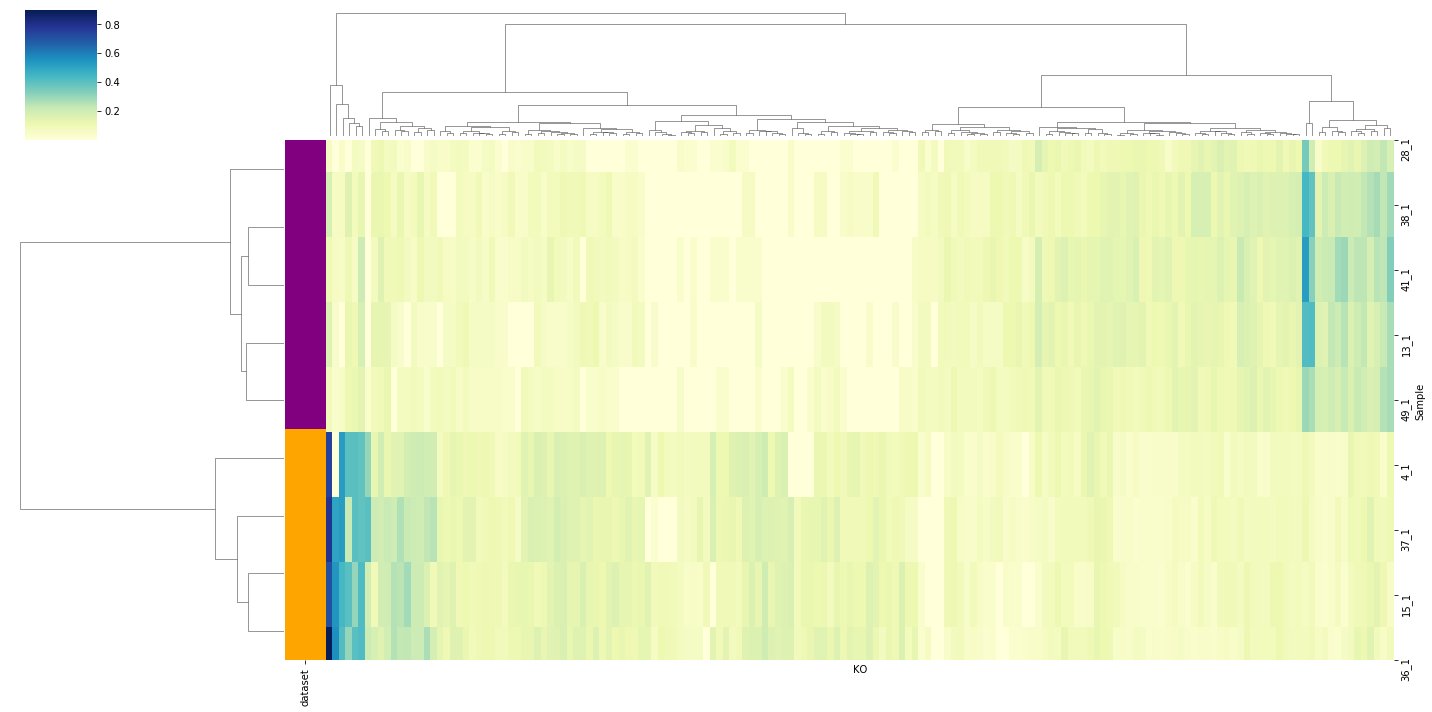

In [50]:
p = sns.clustermap(df3_sqrt, cmap='YlGnBu', figsize=(20,10), xticklabels=False, method='ward', metric='euclidean', row_colors = sample_colors)

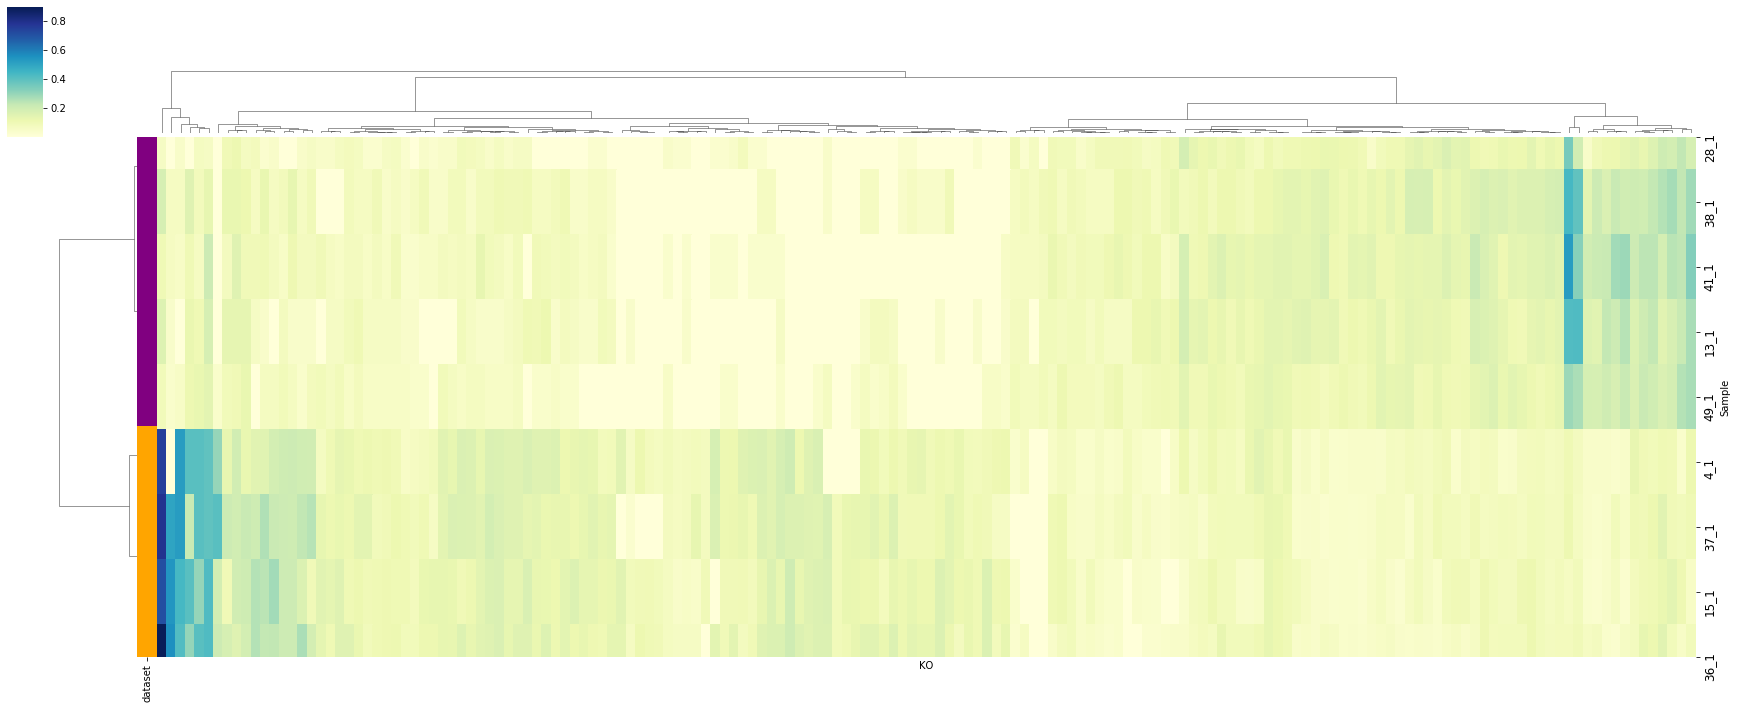

In [51]:
p = sns.clustermap(df3_sqrt, cmap='YlGnBu', method='ward', metric='euclidean', xticklabels=False, row_colors = sample_colors)
hm = p.ax_heatmap.get_position()
plt.setp(p.ax_heatmap.yaxis.get_majorticklabels(), fontsize=12)
plt.setp(p.ax_heatmap.xaxis.get_majorticklabels(), fontsize=18)
p.ax_heatmap.set_position([hm.x0, hm.y0, hm.width*3, hm.height])
col = p.ax_col_dendrogram.get_position()
row = p.ax_row_dendrogram.get_position()
p.ax_col_dendrogram.set_position([col.x0, col.y0, col.width*3, col.height*0.5])
p.ax_row_dendrogram.set_position([row.x0+0.07, row.y0, row.width*0.75, row.height])

In [52]:
p.savefig("All_SD_KOs_log.png")